# Movable Emojis

## Imports

In [23]:
from controllable_nca.experiments.movable_emoji.trainer import MovableEmojiNCATrainer
from controllable_nca.experiments.movable_emoji.movable_emoji_dataset import MovableEmojiDataset
from controllable_nca.nca import ControllableNCA
import torch

### Dataset

In [5]:
import matplotlib.pyplot as plt
import torch
from einops import rearrange

from controllable_nca.dataset import NCADataset
from controllable_nca.utils import load_emoji, rgb


def plot_img(img):
    with torch.no_grad():
        rgb_image = rgb(img, False).squeeze().detach().cpu().numpy()
    rgb_image = rearrange(rgb_image, "c w h -> w h c")
    _ = plt.imshow(rgb_image)
    plt.show()


def draw_in_grid(img, x=None, y=None, grid_size=64):
    with torch.no_grad():
        if x is None:
            x = grid_size // 2
        if y is None:
            y = grid_size // 2

        img_size = img.size(-1)
        center = img_size // 2
        grid = torch.zeros(1, img.size(1), grid_size, grid_size, device=img.device)

        min_x = x - center
        min_x_diff = 0 - min(0, min_x)
        max_x = x + center
        max_x_diff = grid_size - max(grid_size, max_x)
        min_x = min_x + max_x_diff + min_x_diff
        max_x = max_x + max_x_diff + min_x_diff

        min_y = y - center
        min_y_diff = 0 - min(0, min_y)
        max_y = y + center
        max_y_diff = grid_size - max(grid_size, max_y)
        min_y = min_y + max_y_diff + min_y_diff
        max_y = max_y + max_y_diff + min_y_diff

        grid[:, :, min_x:max_x, min_y:max_y] += img
        return grid, (min_x + center, min_y + center)


class MovableEmojiDataset(NCADataset):
    def __init__(self, emoji: str = "🦎", grid_size=64, image_size=32):
        super().__init__()
        self.grid_size = grid_size
        self.image_size = image_size
        self.emoji = emoji
        self.x = load_emoji(emoji, 40, image_size).unsqueeze(0)

    def draw(self, x=None, y=None, substrate=None):
        if substrate is None:
            substrate = self.x
        return draw_in_grid(substrate.clone(), x=x, y=y, grid_size=self.grid_size)

    def target_size(self):
        return (4, self.grid_size, self.grid_size)

    def visualize(self, x=None, y=None):
        grid, coords = self.draw(x, y)
        plot_img(grid)

    def to(self, device: torch.device):
        self.x = self.x.to(device)

    def num_goals(self) -> int:
        return 5


dataset = MovableEmojiDataset(grid_size=64, image_size=32)

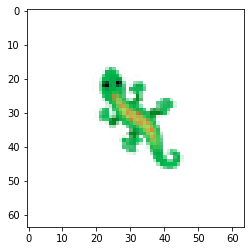

In [6]:
dataset.visualize(32, 32)

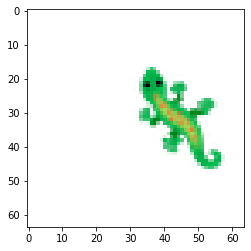

In [7]:
dataset.visualize(32, 48)

### Make NCA

In [8]:
NUM_HIDDEN_CHANNELS=32

nca =  ControllableNCA(num_goals=dataset.num_goals(), target_shape=dataset.target_size(), living_channel_dim=3, num_hidden_channels=NUM_HIDDEN_CHANNELS, cell_fire_rate=1.0)

In [9]:
device = torch.device('cuda')
nca = nca.to(device)
dataset.to(device)

### Make Trainer

In [10]:
trainer = MovableEmojiNCATrainer(nca, dataset, nca_steps=[48, 64], lr=1e-3, num_damaged=0, damage_radius=3, device=device, pool_size=256)

Writing to tensorboard_logs/2022-04-27 01:40:43.330847


In [ ]:
# trainer.train(batch_size=24, epochs=100000)

## Visualizer

#### load pretrained nca

In [14]:
nca.load("../saved_models/movable_salamander.pt")

In [15]:
from threading import Event, Thread

import cv2
import numpy as np
import torch
from einops import rearrange
from ipycanvas import Canvas, hold_canvas  # noqa
from ipywidgets import Button, HBox, VBox

from controllable_nca.experiments.movable_emoji.trainer import MovableEmojiNCATrainer
from controllable_nca.utils import rgb


def to_numpy_rgb(x, use_rgb=False):
    return rearrange(
        np.squeeze(rgb(x, use_rgb).detach().cpu().numpy()), "c x y -> x y c"
    )


class MovableEmojiVisualizer:
    def __init__(
        self,
        trainer: MovableEmojiNCATrainer,
        image_size,
        rgb: bool = False,
        canvas_scale=5,
        damage_radius: int = 5,
    ):
        self.trainer = trainer
        self.current_state = None
        self.current_goal = None

        self.image_size = image_size
        self.rgb = rgb
        self.canvas_scale = canvas_scale
        self.canvas_size = self.image_size * self.canvas_scale

        self.canvas = Canvas(width=self.canvas_size, height=self.canvas_size)
        self.stopped = Event()

        self.current_goal = torch.tensor(0, device=self.trainer.device)

        self.device = self.trainer.device
        self.damage_radius = damage_radius
        self.current_state = self.trainer.nca.generate_seed(1).to(self.device)

        def button_fn(class_num):
            def start(btn):
                self.current_goal = torch.tensor(class_num, device=self.trainer.device)
                if self.stopped.isSet():
                    self.stopped.clear()
                    Thread(target=self.loop).start()

            return start

        button_list = []
        for i in range(5):
            button_list.append(Button(description="{}".format(i)))
            button_list[-1].on_click(button_fn(i))

        self.vbox = VBox(button_list)

        self.stop_btn = Button(description="Stop")

        def stop(btn):
            if not self.stopped.isSet():
                self.stopped.set()

        self.stop_btn.on_click(stop)

    def draw_image(self, rgb):
        with hold_canvas(self.canvas):
            rgb = np.squeeze(rearrange(rgb, "b c w h -> b w h c"))
            self.canvas.clear()  # Clear the old animation step
            self.canvas.put_image_data(
                cv2.resize(
                    rgb * 255.0,
                    (self.canvas_size, self.canvas_size),
                    interpolation=cv2.INTER_NEAREST,
                ),
                0,
                0,
            )

    def loop(self):
        with torch.no_grad():
            self.current_state = self.trainer.nca.generate_seed(1).to(self.device)
            while not self.stopped.wait(0.02):  # the first call is in `interval` secs
                # update_particle_locations()
                self.draw_image(self.trainer.to_rgb(self.current_state))
                self.current_state = self.trainer.nca.grow(
                    self.current_state, 1, self.current_goal
                )

    def visualize(self):
        Thread(target=self.loop).start()
        display(self.canvas, HBox([self.stop_btn, self.vbox]))  # noqa


In [16]:
viz = MovableEmojiVisualizer(trainer, 64)
viz.visualize()

Canvas(height=320, width=320)

## Test Goal Dropout with various values for cell_fire_rate

In [17]:
from einops import rearrange
import numpy as np
import matplotlib.pyplt as plt

def get_movements(trainer, cell_fire_rate=1.0):
    original_cell_fire_rate = trainer.nca.cell_fire_rate 
    trainer.nca.cell_fire_rate = cell_fire_rate

    with torch.no_grad():
        x = trainer.nca.generate_seed(1, size=128).to(trainer.device)
        rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
        out = [rgb]

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(1, device=trainer.device)
        for i in range(128):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)

        current_goal = torch.tensor(3, device=trainer.device)
        for i in range(128):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)

        current_goal = torch.tensor(2, device=trainer.device)
        for i in range(256):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)
    
        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)

        current_goal = torch.tensor(4, device=trainer.device)
        for i in range(128):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)

        current_goal = torch.tensor(2, device=trainer.device)
        for i in range(256):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)

        current_goal = torch.tensor(4, device=trainer.device)
        for i in range(64):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            out.append(rgb)

        current_goal = torch.tensor(0, device=trainer.device)
        for i in range(96):
            x = trainer.nca.grow(
                        x, 1, current_goal
                    )
            rgb = np.squeeze(rearrange(trainer.to_rgb(x), "b c w h -> b w h c"))
            # out.append(rgb)
        trainer.nca.cell_fire_rate = original_cell_fire_rate
        return out

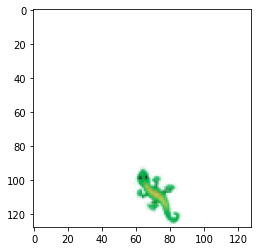

In [20]:
from matplotlib import pyplot as plt
from celluloid import Camera

outs = get_movements(trainer)

fig = plt.figure()
camera = Camera(fig)
for substrate in outs:
    plt.imshow(substrate)
    camera.snap()
animation = camera.animate(blit = False, interval = 16)

from IPython.display import HTML

HTML(animation.to_html5_video())

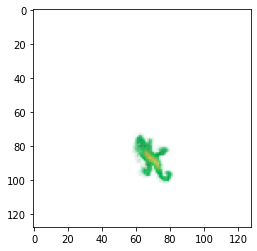

In [21]:
from matplotlib import pyplot as plt
from celluloid import Camera

outs = get_movements(trainer, cell_fire_rate=0.5)

fig = plt.figure()
camera = Camera(fig)
for substrate in outs:
    plt.imshow(substrate)
    camera.snap()
animation = camera.animate(blit = False, interval = 16)

from IPython.display import HTML

HTML(animation.to_html5_video())

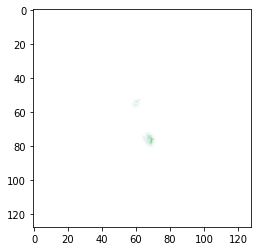

In [22]:
from matplotlib import pyplot as plt
from celluloid import Camera

outs = get_movements(trainer, cell_fire_rate=0.25)

fig = plt.figure()
camera = Camera(fig)
for substrate in outs:
    plt.imshow(substrate)
    camera.snap()
animation = camera.animate(blit = False, interval = 16)

from IPython.display import HTML

HTML(animation.to_html5_video())